# XGBoost regression

## Setup

In [19]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
print("XGB Version:", xgb.__version__)

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

XGB Version: 1.5.1


## Data

- See [](hitters_data.ipynb) for details about the data preprocessing steps.

In [20]:
X, y = datasets.fetch_california_housing(return_X_y=True, as_frame=True) 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## Model

- Define hyperparameters

In [22]:
params = {
    "n_estimators":50,
    "max_depth": 4,
    "learning_rate": 0.01,
    "eval_metric": "rmse",
    "early_stopping_rounds": 5,
}

- Prepare evaluation data
- If there’s more than one item in eval_set, the last entry will be used for early stopping.
- If we want to plot the learning curves for both training and test data, we need to provide both training and test data as eval_set

In [23]:
eval_set = [(X_train, y_train), (X_test, y_test)]

- Build and fit model

In [24]:
reg = xgb.XGBRegressor(**params)

reg.fit(X_train, 
        y_train, 
        verbose=True,
        eval_set= eval_set)

[21:21:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:1.93036	validation_1-rmse:1.93354
[1]	validation_0-rmse:1.91394	validation_1-rmse:1.91718
[2]	validation_0-rmse:1.89770	validation_1-rmse:1.90098
[3]	validation_0-rmse:1.88164	validation_1-rmse:1.88499
[4]	validation_0-rmse:1.86577	validation_1-rmse:1.86919
[5]	validation_0-rmse:1.85008	validation_1-rmse:1.85355
[6]	validation_0-rmse:1.83458	validation_1-rmse:1.83820
[7]	validation_0-rmse:1.81924	validation_1-rmse:1.82291
[8]	validation_0-rmse:1.80407	validation_1-rmse:1.80786
[9]	validation_0-rmse:1.78907	validation_1-rmse:1.79295
[10

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=5,
             enable_categorical=False, eval_metric='rmse', gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=10, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [25]:
reg.evals_result()

{'validation_0': OrderedDict([('rmse',
               [1.93036,
                1.913936,
                1.897696,
                1.881644,
                1.865773,
                1.850085,
                1.834582,
                1.819236,
                1.80407,
                1.789071,
                1.774255,
                1.759603,
                1.745095,
                1.730761,
                1.716599,
                1.70256,
                1.688709,
                1.674996,
                1.661438,
                1.647982,
                1.634684,
                1.621588,
                1.608669,
                1.595824,
                1.583178,
                1.570625,
                1.558256,
                1.546054,
                1.533939,
                1.521966,
                1.510154,
                1.498459,
                1.486938,
                1.475511,
                1.464224,
                1.453085,
                1.442069,
  

- The best iteration obtained by early stopping. This attribute is 0-based, for instance if the best iteration is the first round, then best_iteration is 0.



In [26]:
reg.best_iteration

49

- Make predictions

In [29]:
y_pred = reg.predict(X_test)

- Obtain RMSE

In [31]:
mean_squared_error(y_test, y_pred, squared = False)

1.3188079378718305

- Save the model

In [32]:
# Save model into JSON format.
reg.save_model("regressor.json")

### Plot training test deviance


- Obtain evaluation metrics

In [33]:
results = reg.evals_result()

- Plot training test deviance

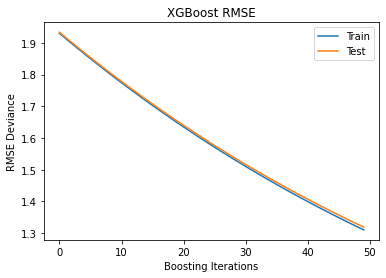

In [34]:
# Prepare x-axis
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')

plt.title('XGBoost RMSE')
plt.xlabel("Boosting Iterations")
plt.ylabel("RMSE Deviance")
plt.legend(loc="upper right");


## Feature importance

- Next, we take a look at the tree based feature importance and the permutation importance.

### Mean decrease in impurity (MDI)

- Mean decrease in impurity (MDI) is a measure of feature importance for decision tree models. 

```{Note}
Visit [this notebook](https://kirenz.github.io/feature-engineering/docs/mdi.html#) to learn more about MDI
```

In [35]:
reg.feature_importances_

array([0.5389647 , 0.04911011, 0.10514385, 0.        , 0.01159318,
       0.17180622, 0.07378276, 0.04959917], dtype=float32)

- Feature importances are provided by the function `plot_importance` 

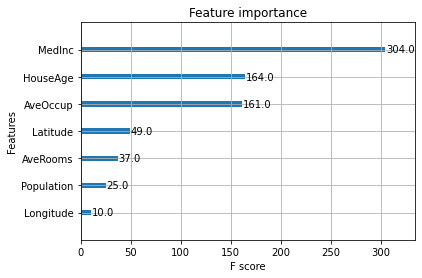

In [37]:
xgb.plot_importance(reg);

### Permutation feature importance

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. 

```{Note}
Visit [this notebook](https://kirenz.github.io/feature-engineering/docs/permutation-feature-importance.html) to learn more about permutation feature importance.
```

In [38]:

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [42]:
result

{'importances_mean': array([0.42380621, 0.01296257, 0.01401125, 0.        , 0.00051886,
        0.06618216, 0.00650385, 0.00071611]),
 'importances_std': array([0.00836628, 0.00211472, 0.00110466, 0.        , 0.00035793,
        0.0039604 , 0.00101385, 0.00013158]),
 'importances': array([[4.13977358e-01, 4.27543189e-01, 4.17442947e-01, 4.16331701e-01,
         4.34321970e-01, 4.41830028e-01, 4.21468045e-01, 4.26686162e-01,
         4.20214924e-01, 4.18245811e-01],
        [1.41752693e-02, 1.48520626e-02, 1.29326333e-02, 1.34002596e-02,
         1.62666310e-02, 7.98938369e-03, 1.34120866e-02, 1.13797786e-02,
         1.32721925e-02, 1.19453894e-02],
        [1.39285213e-02, 1.34339251e-02, 1.34097396e-02, 1.38147796e-02,
         1.18717642e-02, 1.37149863e-02, 1.36394990e-02, 1.57344377e-02,
         1.48039360e-02, 1.57608739e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        

In [44]:
tree_importances = pd.Series(result.importances_mean)

In [41]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances[sorted_idx], align="center")

#plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

NameError: name 'tree_importances' is not defined

- Same data plotted as boxplot:

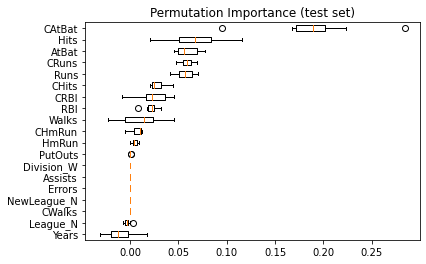

In [59]:
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")
plt.show()

- We observe that the same features are detected as most important using both methods. Although the relative importances vary (especially for feature `Years`).

## Hyperparameter Tuning